<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/instance_segmentation_yolov8_v11_20230719.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Instance Segmentation with YOLOv8 version 11
References:<br>
https://docs.ultralytics.com/usage/cfg/#tasks <br>
how YOLO v8 works: https://openmmlab.medium.com/dive-into-yolov8-how-does-this-state-of-the-art-model-work-10f18f74bab1 <br>

about COCO dataset and format:<br>
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047<br>

training with yolov8:<br>
https://learnopencv.com/train-yolov8-on-custom-dataset/


Run 1: <br>
Split: 0.85 & 0.15, LR0 = 0.01, batch = 16, droupout = 0.5, patience = 10, epoch = 60 (early stopping 43), image size =1024   data = /gdrive/MyDrive/DATA/HuBMAP/images


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!ls /gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset

coco.yaml  train  val


In [ ]:
!ls /content

sample_data


In [ ]:
!pip install colorama

In [ ]:
# libraries needed to create the create the dataset in COCO format
from itertools import chain
import json
import os
import glob
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# use this code to clear output
from IPython import display
from google.colab import files
#display.clear_output()

In [ ]:
#@title modified COCO dataset
# class for creating the dataset
class COCODataset_mod:
    def __init__(self, images_dirpath: str,
                 annotations_filepath: str,
                 length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_dirpath = images_dirpath

        self.annotations_filepath = annotations_filepath
        self.modified_dirpath = os.path.join(os.getcwd(),"modified")
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.modified_dirpath), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __modify_image(self, image_path: str, identifier: str) -> str:
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      cv2.imwrite(self.modified_dirpath + identifier + '.tif',image)
      return self.modified_dirpath + identifier + '.tif'

    def __modify_label(self, label_path: str, identifier: str) -> str:
      with open(label_path, 'r') as file:
          lines = file.readlines()


    def __copy_image(self, dst_path: str, identifier: str) -> str:

        # make temporay directory under under cwd and call it modified
        image_path = os.path.join(self.images_dirpath, f"{identifier}.tif")
        modified_image_path = self.__modify_image(image_path, identifier)

        shutil.copyfile(modified_image_path, dst_path)

        return dst_path


    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}"
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio()
        self.__prepare_dirs()
        self.__splitfolders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.__finalizing(count_dict)

        if make_config:
            config = self.get_config()
            self.write_config(config)
            self.display_config(config)

In [ ]:
# class for creating the dataset
class COCODataset:
    def __init__(self, images_dirpath: str, annotations_filepath: str, length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_dirpath = images_dirpath
        self.annotations_filepath = annotations_filepath
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_dirpath, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}"
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio() # define size of train and val
        self.__prepare_dirs() # crete dire directories train and val and sub-directories images and labels for each
        self.__splitfolders() # copies image from source to destination folder and creates text file containing annotation info to destination folder
        count_dict = self.__count_dataset() # count number of records(images / labels) are there in train and val subdirectories
        self.__check_sanity(count_dict) # check number of labels and images correct for train and val subdirectories
        self.__finalizing(count_dict) # displays dataset organization

        if make_config:
            config = self.get_config()  # get train and val directory path path information
            self.write_config(config) # add config to coco.yaml file
            self.display_config(config) # display configuration organization

In [ ]:
# instantiate a COCODataset object
path = '/gdrive/MyDrive/DATA/HuBMAP/'
coco = COCODataset(
    annotations_filepath= path + 'polygons.jsonl',
    images_dirpath=path + 'images/'
)

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [ ]:
coco(train_size=0.85, classes=[0, 1, 2])

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]


~ HuBMAP Dataset Structure ~


          ├── dataset
          │   │
          │   ├── train
          │   │   └── labels
          │   │   └── images
          │   │
          │   ├── val
          │   │   └── labels
          │   │   └── images
            
-> Success
Train dataset: 1388
Val dataset: 245

~ HuBMAP Config Structure ~


      │   │
      │   ├── train
      │   │   └── /content/dataset/train/images
      │   │
      │   │
      │   ├── val
      │   │   └── /content/dataset/val/images
      │   │
      │   │
      │   ├── names
      │   │   └── blood_vessel glomerulus unsure
        
-> Success
Number of classes: 3
Classes: blood_vessel glomerulus unsure


In [ ]:
#!zip -r /content/dataset.zip /content/dataset


In [ ]:
#files.download('/content/dataset.zip')

In [ ]:
def parse_jsonl(path):
  with open(path, 'r') as json_file:
    jsonl_samples = [
      json.loads(line)
      for line in tqdm(json_file, desc="Processing polygons", total=1633)]
  return jsonl_samples

In [ ]:
annotations = parse_jsonl('/gdrive/MyDrive/DATA/HuBMAP/polygons.jsonl')

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [ ]:
annotations[2]['annotations'][3]['type']

'blood_vessel'

In [ ]:
labels = os.listdir('/content/dataset/train/labels')

In [ ]:
!cat labels[0]

7[>4;2m="labels[0]" [New File]▽  [>c]10;?]11;?~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                 

In [ ]:
!ls dataset

ls: cannot access 'dataset': No such file or directory


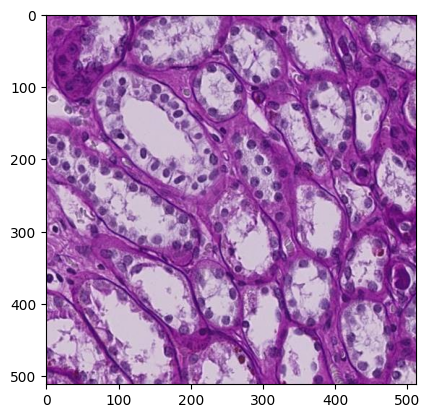

In [ ]:
dirlist = os.listdir("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/train/images/")
random_num = np.random.randint(0, len(dirlist))
image = Image.open("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/train/images/"+ dirlist[random_num])
plt.imshow(image)
plt.show()

In [ ]:
# install ultralytics version 8.0.131
!pip install ultralytics==8.0.131
display.clear_output()

In [ ]:
pip show ultralytics

Name: ultralytics
Version: 8.0.131
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, Pillow, psutil, PyYAML, requests, scipy, seaborn, torch, torchvision, tqdm
Required-by: 


In [ ]:
# install pycocotools version 2.0.6
!pip install pycocotools==2.0.6
display.clear_output()


In [ ]:
pip show pycocotools


Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [ ]:
from pycocotools import _mask as coco_mask
import ultralytics
from ultralytics import YOLO



In [ ]:
ultralytics.checks()


Ultralytics YOLOv8.0.131 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.3/166.8 GB disk)


In [ ]:
!nvidia-smi

Thu Jul 20 03:34:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    42W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=1024,

        # Training parameters
        epochs=60,
        batch=16,
        workers=8,
        val=True,
        device= 0,

        # Optimization parameters
        lr0=0.01,
        patience=10,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
        dropout = 0.5
    )

In [ ]:
if __name__ == '__main__':
    main()

100%|██████████| 137M/137M [00:07<00:00, 18.9MB/s]
New https://pypi.org/project/ultralytics/8.0.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.131 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/coco.yaml, epochs=60, patience=10, batch=16, imgsz=1024, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

In [ ]:
files.download('/content/HuBMAP/yolov8x-seg/weights/best.pt')

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
dirlist = os.listdir("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images")
print(dirlist[:5])

['da1c6d6657e9.tif', 'd9808586aef2.tif', 'da054a47370e.tif', 'da774b6f9cd1.tif', 'da2863316247.tif']



image 1/1 /gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images/fbd64e93f84d.tif: 1024x1024 7 blood_vessels, 30.3ms
Speed: 6.1ms preprocess, 30.3ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)


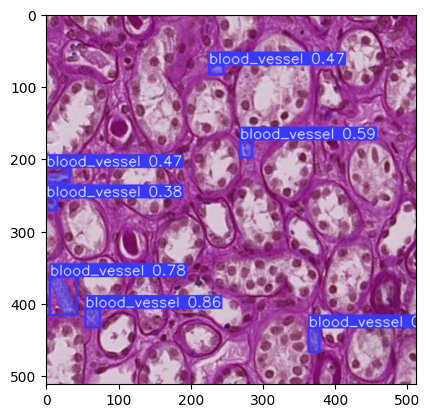

In [ ]:
model = YOLO("/content/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images/fbd64e93f84d.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

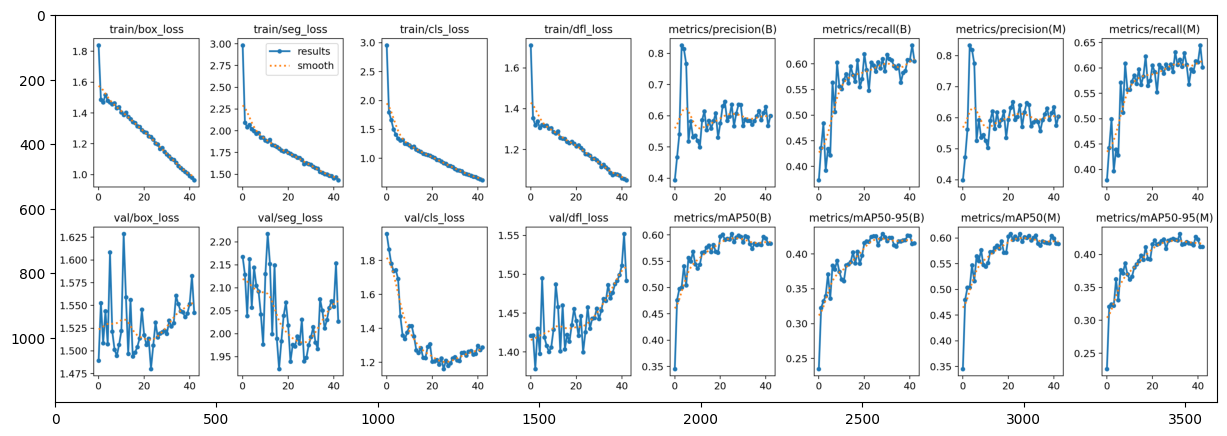

In [ ]:
F1_curve = Image.open("/content/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()

In [ ]:
results = pd.read_csv("/content/HuBMAP/yolov8x-seg/results.csv")
results.head()
results.to_csv('/gdrive/MyDrive/DATA/HuBMAP/Results/is_yolov8_v11_20230719.csv')

In [ ]:
results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.83960,2.9835,2.95750,1.7110,0.39327,0.37301,0.34542,0.23487,0.39835,0.37881,0.34549,0.22608,1.4892,2.1676,1.9566,1.4209,0.070345,0.003295,0.003295
1,1,1.48700,2.0922,1.79790,1.3536,0.46723,0.43623,0.47617,0.32255,0.47225,0.44287,0.48009,0.32075,1.5526,2.1286,1.8657,1.4212,0.040235,0.006519,0.006519
2,2,1.46880,2.0429,1.66010,1.3196,0.54113,0.48398,0.49766,0.33215,0.56203,0.49915,0.50358,0.32441,1.5084,2.0386,1.7819,1.3783,0.010016,0.009633,0.009633
3,3,1.51780,2.0686,1.50190,1.3379,0.82615,0.39186,0.49993,0.33978,0.83344,0.39695,0.50365,0.32216,1.5438,2.1625,1.7384,1.4301,0.009505,0.009505,0.009505
4,4,1.47910,2.0182,1.40940,1.3059,0.81398,0.43447,0.54065,0.37098,0.81836,0.43941,0.54712,0.36239,1.5074,2.0565,1.7436,1.3975,0.009505,0.009505,0.009505
5,5,1.46880,1.9982,1.34080,1.3209,0.76670,0.42149,0.50439,0.33624,0.77441,0.42784,0.51607,0.33067,1.6085,2.1443,1.6915,1.4949,0.009340,0.009340,0.009340
6,6,1.45770,1.9659,1.30730,1.3156,0.51755,0.56358,0.55657,0.38332,0.52580,0.57114,0.56468,0.37636,1.5212,2.1049,1.4713,1.4189,0.009175,0.009175,0.009175
7,7,1.46250,1.9742,1.31750,1.3175,0.58163,0.50600,0.54974,0.37791,0.59268,0.51227,0.55538,0.37158,1.5015,2.0918,1.3580,1.4079,0.009010,0.009010,0.009010
8,8,1.43160,1.9216,1.25500,1.3034,0.53174,0.60280,0.56820,0.39061,0.53604,0.60860,0.57690,0.38675,1.4945,2.0421,1.3382,1.4004,0.008845,0.008845,0.008845
9,9,1.43740,1.9240,1.24870,1.3054,0.53629,0.55604,0.54427,0.37485,0.54472,0.55708,0.54746,0.36985,1.5069,1.9763,1.3752,1.4061,0.008680,0.008680,0.008680


In [ ]:
plt.figure

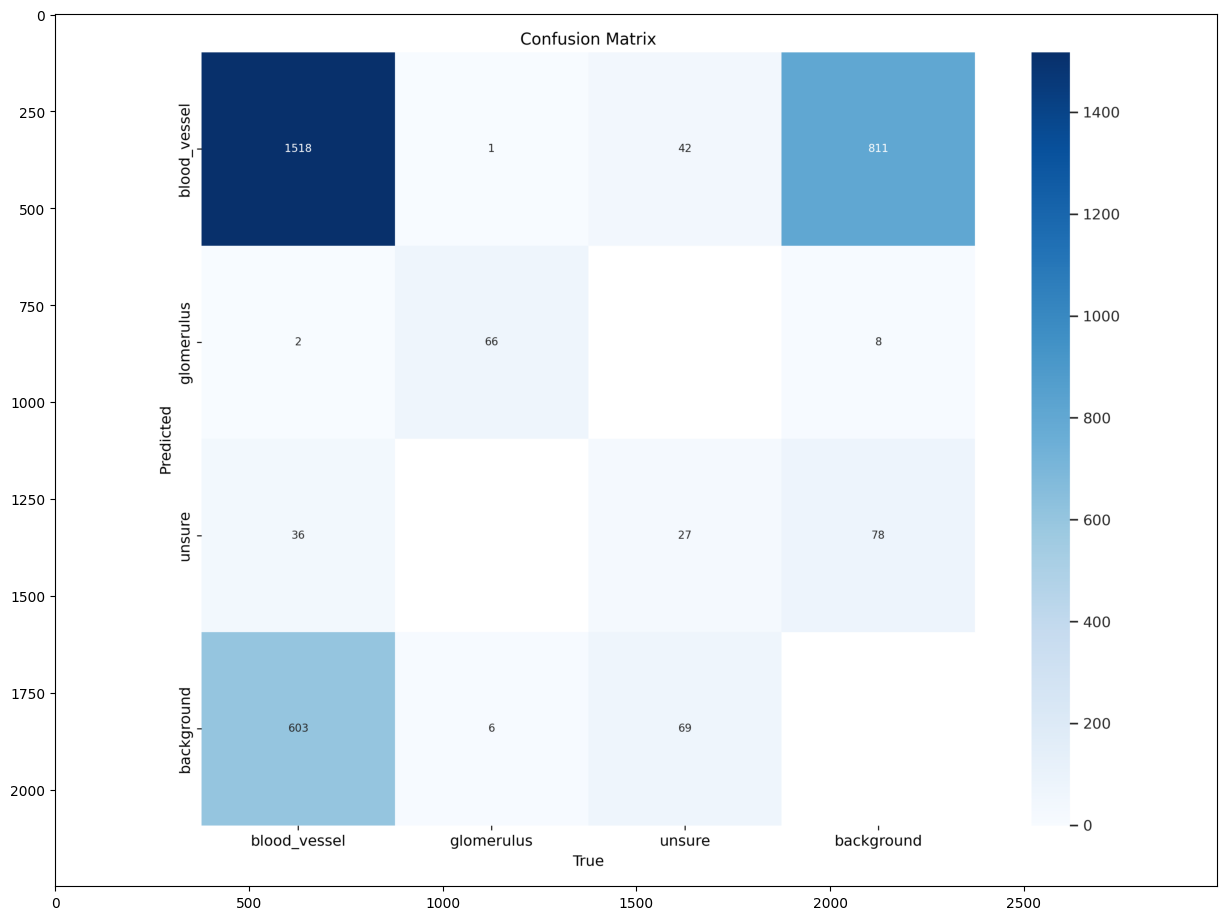

In [ ]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix.png")
plt.imshow(confusion_matrix)
plt.show()


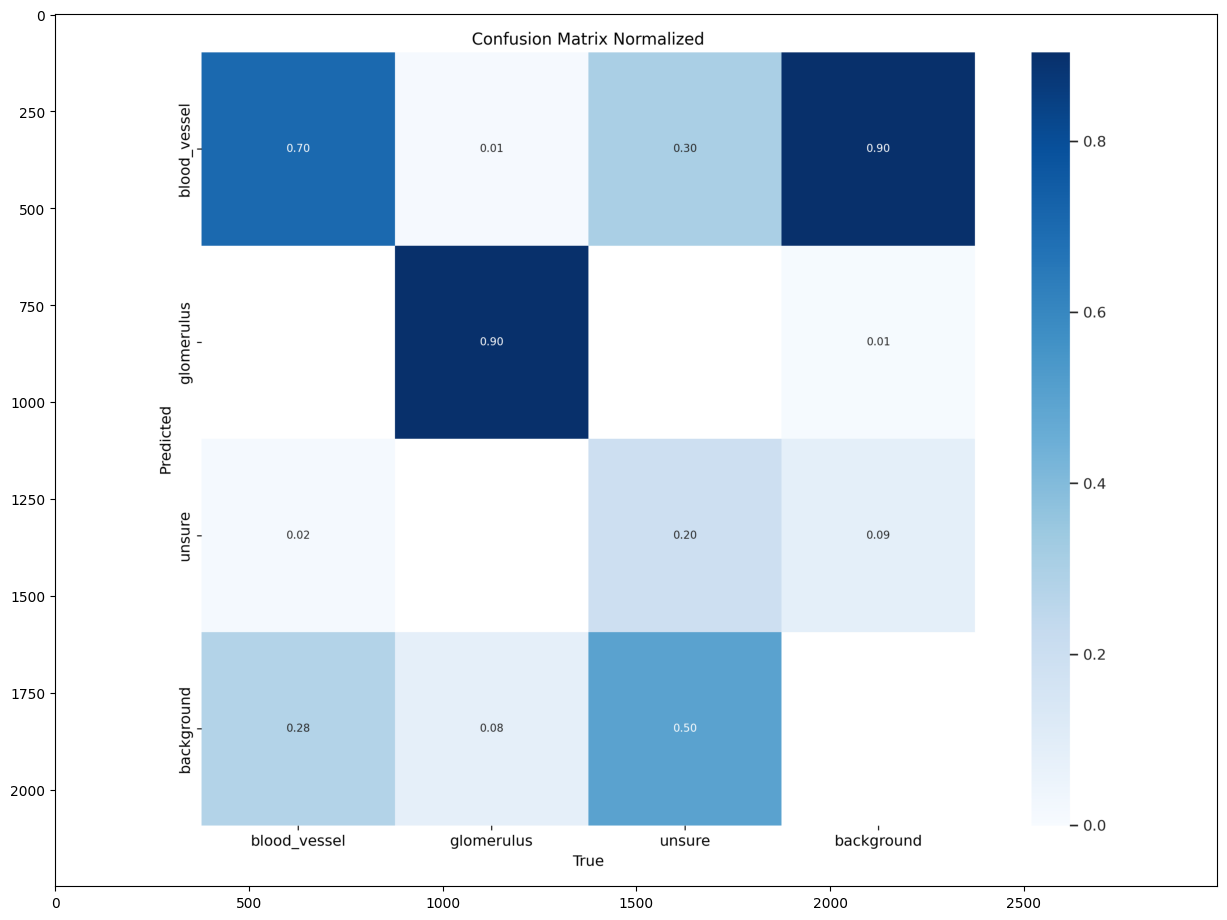

In [ ]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix_normalized.png")
plt.imshow(confusion_matrix)
plt.show()

In [ ]:
results = pd.read_csv("/gdrive/MyDrive/DATA/HuBMAP/Results/is_yolov8_v11_20230719.csv",index_col=0)
results.columns = results.columns.str.strip()

results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.83960,2.9835,2.95750,1.7110,0.39327,0.37301,0.34542,0.23487,0.39835,0.37881,0.34549,0.22608,1.4892,2.1676,1.9566,1.4209,0.070345,0.003295,0.003295
1,1,1.48700,2.0922,1.79790,1.3536,0.46723,0.43623,0.47617,0.32255,0.47225,0.44287,0.48009,0.32075,1.5526,2.1286,1.8657,1.4212,0.040235,0.006519,0.006519
2,2,1.46880,2.0429,1.66010,1.3196,0.54113,0.48398,0.49766,0.33215,0.56203,0.49915,0.50358,0.32441,1.5084,2.0386,1.7819,1.3783,0.010016,0.009633,0.009633
3,3,1.51780,2.0686,1.50190,1.3379,0.82615,0.39186,0.49993,0.33978,0.83344,0.39695,0.50365,0.32216,1.5438,2.1625,1.7384,1.4301,0.009505,0.009505,0.009505
4,4,1.47910,2.0182,1.40940,1.3059,0.81398,0.43447,0.54065,0.37098,0.81836,0.43941,0.54712,0.36239,1.5074,2.0565,1.7436,1.3975,0.009505,0.009505,0.009505
5,5,1.46880,1.9982,1.34080,1.3209,0.76670,0.42149,0.50439,0.33624,0.77441,0.42784,0.51607,0.33067,1.6085,2.1443,1.6915,1.4949,0.009340,0.009340,0.009340
6,6,1.45770,1.9659,1.30730,1.3156,0.51755,0.56358,0.55657,0.38332,0.52580,0.57114,0.56468,0.37636,1.5212,2.1049,1.4713,1.4189,0.009175,0.009175,0.009175
7,7,1.46250,1.9742,1.31750,1.3175,0.58163,0.50600,0.54974,0.37791,0.59268,0.51227,0.55538,0.37158,1.5015,2.0918,1.3580,1.4079,0.009010,0.009010,0.009010
8,8,1.43160,1.9216,1.25500,1.3034,0.53174,0.60280,0.56820,0.39061,0.53604,0.60860,0.57690,0.38675,1.4945,2.0421,1.3382,1.4004,0.008845,0.008845,0.008845
9,9,1.43740,1.9240,1.24870,1.3054,0.53629,0.55604,0.54427,0.37485,0.54472,0.55708,0.54746,0.36985,1.5069,1.9763,1.3752,1.4061,0.008680,0.008680,0.008680


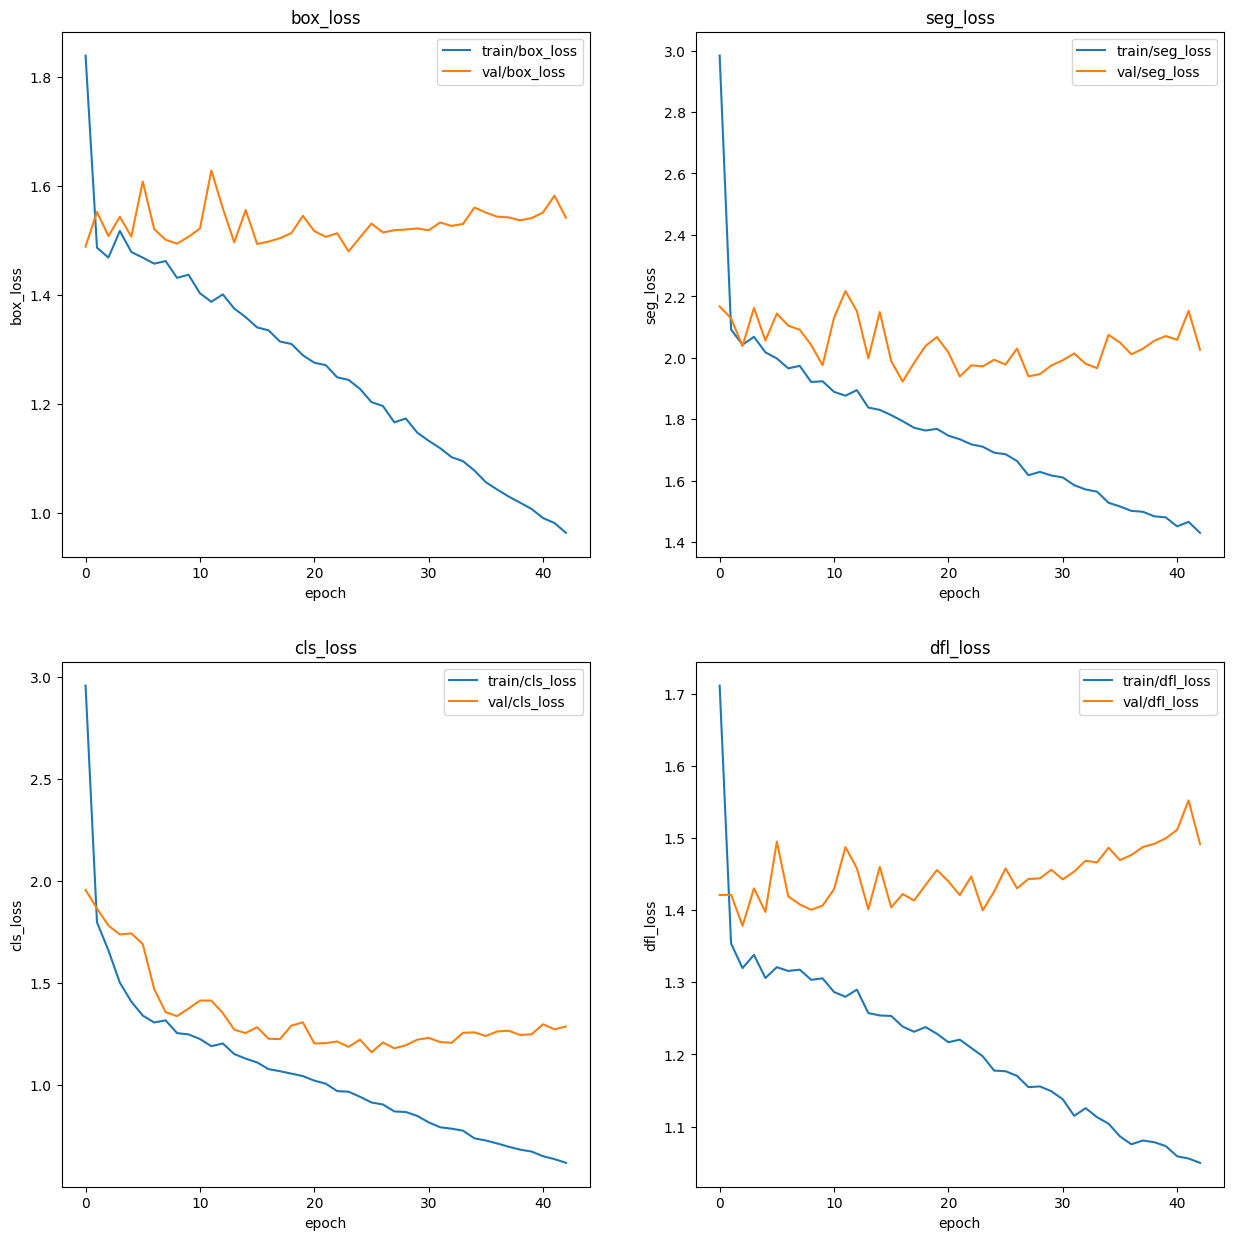

In [ ]:
plt.figure(figsize=(15,15))

loss_labels = results.columns.tolist()[1:5] + results.columns.tolist()[13:17]
for idx in range(4):
  plt.subplot(2,2,idx+1)
  plt.plot(results['epoch'],results[loss_labels[idx]],label = loss_labels[idx])
  plt.plot(results['epoch'],results[loss_labels[idx+4]],label = loss_labels[idx+4])
  plt.legend(loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel(loss_labels[idx].split('/')[1])
  plt.title(loss_labels[idx].split('/')[1])



plt.show();



In [ ]:
results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.83960,2.9835,2.95750,1.7110,0.39327,0.37301,0.34542,0.23487,0.39835,0.37881,0.34549,0.22608,1.4892,2.1676,1.9566,1.4209,0.070345,0.003295,0.003295
1,1,1.48700,2.0922,1.79790,1.3536,0.46723,0.43623,0.47617,0.32255,0.47225,0.44287,0.48009,0.32075,1.5526,2.1286,1.8657,1.4212,0.040235,0.006519,0.006519
2,2,1.46880,2.0429,1.66010,1.3196,0.54113,0.48398,0.49766,0.33215,0.56203,0.49915,0.50358,0.32441,1.5084,2.0386,1.7819,1.3783,0.010016,0.009633,0.009633
3,3,1.51780,2.0686,1.50190,1.3379,0.82615,0.39186,0.49993,0.33978,0.83344,0.39695,0.50365,0.32216,1.5438,2.1625,1.7384,1.4301,0.009505,0.009505,0.009505
4,4,1.47910,2.0182,1.40940,1.3059,0.81398,0.43447,0.54065,0.37098,0.81836,0.43941,0.54712,0.36239,1.5074,2.0565,1.7436,1.3975,0.009505,0.009505,0.009505
5,5,1.46880,1.9982,1.34080,1.3209,0.76670,0.42149,0.50439,0.33624,0.77441,0.42784,0.51607,0.33067,1.6085,2.1443,1.6915,1.4949,0.009340,0.009340,0.009340
6,6,1.45770,1.9659,1.30730,1.3156,0.51755,0.56358,0.55657,0.38332,0.52580,0.57114,0.56468,0.37636,1.5212,2.1049,1.4713,1.4189,0.009175,0.009175,0.009175
7,7,1.46250,1.9742,1.31750,1.3175,0.58163,0.50600,0.54974,0.37791,0.59268,0.51227,0.55538,0.37158,1.5015,2.0918,1.3580,1.4079,0.009010,0.009010,0.009010
8,8,1.43160,1.9216,1.25500,1.3034,0.53174,0.60280,0.56820,0.39061,0.53604,0.60860,0.57690,0.38675,1.4945,2.0421,1.3382,1.4004,0.008845,0.008845,0.008845
9,9,1.43740,1.9240,1.24870,1.3054,0.53629,0.55604,0.54427,0.37485,0.54472,0.55708,0.54746,0.36985,1.5069,1.9763,1.3752,1.4061,0.008680,0.008680,0.008680
